In [17]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from deepymod.analysis import load_tensorboard

In [18]:
# settings
sns.set(context='paper', style='white')
col_width = 5.5 # neurips style column width in inches

# Single run plot

In [19]:
# loading data
df_bayes = load_tensorboard("runs/bayes_run_0/")
df_pinn = load_tensorboard("runs/pinn_run_0/")
df_mt = load_tensorboard("runs/multitask_run_0/")

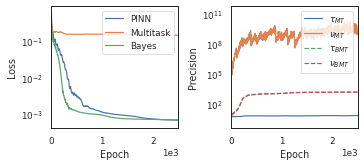

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(0.9 * col_width, 0.4 * col_width), constrained_layout=True)

ax = axes[0]
ax.plot(df_pinn.index, df_pinn.loss, label='PINN')
ax.plot(df_mt.index, df_mt.reg + df_mt.mse, label='Multitask')
ax.plot(df_bayes.index, df_bayes.reg + df_bayes.mse, label='Bayes')

ax.ticklabel_format(axis='x', style='sci', scilimits=[0, 0])
ax.legend(loc='upper right')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.set_xlim([0, 2500])

ax = axes[1]
ax.plot(df_mt.index, df_mt.tau, label=r'$\tau_{MT}$')
ax.plot(df_mt.index, df_mt.nu, label=r'$\nu_{MT}$')

ax.plot(df_bayes.index, df_bayes.tau, label=r'$\tau_{BMT}$', linestyle='--')
ax.plot(df_bayes.index, df_bayes.nu, label=r'$\nu_{BMT}$', linestyle='--')


ax.ticklabel_format(axis='x', style='sci', scilimits=[0, 0])
ax.legend(loc='upper right')
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')
ax.set_yscale('log')
ax.set_xlim([0, 2500])

plt.savefig('multitask.pdf', bbox_inches='tight')